In [1]:
from plancklens import utils

import camb
from camb import model, initialpower
import numpy as np
import matplotlib.pyplot as plt

import healpy as hp

from os.path import join as opj
import os
from plancklens import utils

cls_path = opj("../", 'data')
#cls_path = opj("/Users/omard/Downloads/", 'giulio')
cls_unl = utils.camb_clfile(opj(cls_path, 'lensedCMB_dmn1_lenspotentialCls.dat'))
cls_len = utils.camb_clfile(opj(cls_path, 'lensedCMB_dmn1_lensedCls.dat'))

cls_original = np.loadtxt(opj(cls_path, 'lensedCMB_dmn1_lenspotentialCls.dat'))

HOME = "../"
tau_dir = opj(HOME, 'data', 'tau_lensing_data')
tau_phi = np.loadtxt(opj(tau_dir, "theory_spectra_optimistic_ptau.txt"))
tau_tau = np.loadtxt(opj(tau_dir, "theory_spectra_optimistic_tautau.txt")) 


ell = np.arange(0, len(cls_unl["tt"])+1)
ns = 1
ACB = 7
cls_alpha = 10**(-ACB)*2*np.pi/(ell*(ell+1))**(ns)
cls_alpha[0] = 0



/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_13848/1886895792.py:30: RuntimeWarning: divide by zero encountered in divide
  cls_alpha = 10**(-ACB)*2*np.pi/(ell*(ell+1))**(ns)


In [2]:
def make_CMB_maps(N,pix_size,ell,DlTT, return_2D_spec = False):
    "makes a realization of a simulated CMB sky map"

    # convert Dl to Cl, we use np.divide to avoid dividing by zero.
    dell = ell * (ell + 1) / 2 / np.pi
    ClTT = DlTT#np.divide(DlTT, dell, where=ell>1)
    
    # set the \ell = 0 and \ell =1 modes to zero as these are unmeasurmable and blow up with the above transform
    ClTT[0:2] = 0.
    
    # make a 2d coordinate system
    ones = np.ones(N)
    inds  = (np.arange(N) - N/2.) /(N-1.)
    X = np.outer(ones,inds)
    Y = np.transpose(X)
    R = np.sqrt(X**2. + Y**2.)
    ang = np.arctan2(Y,X)   ## we now need this angle to handle the EB <--> QU rotation
    
    # now make a set of 2d CMB masks for the T, E, and B maps
    ell_scale_factor = 2. * np.pi / (pix_size/60. * np.pi/180.)
    ell2d = R * ell_scale_factor
    ClTT_expanded = np.zeros(int(ell2d.max())+1)
    ClTT_expanded[0:(ClTT.size)] = ClTT
    CLTT2d = ClTT_expanded[ell2d.astype(int)]
    
    # now make a set of gaussian random fields that will be turned into the CMB maps
    randomn_array_for_T = np.fft.fft2(np.random.normal(0,1,(N,N)))
    
    ## make the T, E, and B maps by multiplying the masks against the random fields
    FT_2d = np.sqrt(CLTT2d) * randomn_array_for_T #T_L
    
    ## convert from fourier space to real space
    CMB_T = np.fft.ifft2(np.fft.fftshift(FT_2d)) /(pix_size /60.* np.pi/180.)
    CMB_T = np.real(CMB_T)    
    ## return the maps
    if return_2D_spec:
        return CMB_T, FT_2d, CLTT2d
    else:
        return CMB_T, FT_2d
  ###############################


def get_ells(N, pix_size):
    # This function returns Fourier wavenumbers for a Cartesian square grid
    N = int(N)
    ones = np.ones(N)
    inds = (np.arange(N) + 0.5 - N / 2.0) / (N - 1.0)
    ell_scale_factor = 2.0 * np.pi
    lx = np.outer(ones, inds) / (pix_size / 60.0 * np.pi / 180.0) * ell_scale_factor
    ly = np.transpose(lx)
    modlmap = np.sqrt(lx**2.0 + ly**2.0)
    return ly, lx, modlmap

In [3]:
N = 2**8
pix_size = 1  # size of a pixel in arcminutes
N_iterations = 16
## variables to set up the map plots
c_min = -400  # minimum for color bar
c_max = 400  # maximum for color bar
X_width = N * pix_size / 60.0  # horizontal map width in degrees
Y_width = N * pix_size / 60.0  # vertical map width in degrees

DlTT,DlEE,DlTE,DlBB = cls_unl["tt"][:6000], cls_unl["ee"][:6000], cls_unl["te"][:6000], cls_unl["bb"][:6000]
ell = np.arange(len(DlTT))

tau_tau_cl = tau_tau[:6000]
alpha_alpha_cl = cls_alpha[:6000]
pp_cl = cls_unl["pp"][:6000]

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_13848/944934927.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(Cl2D))


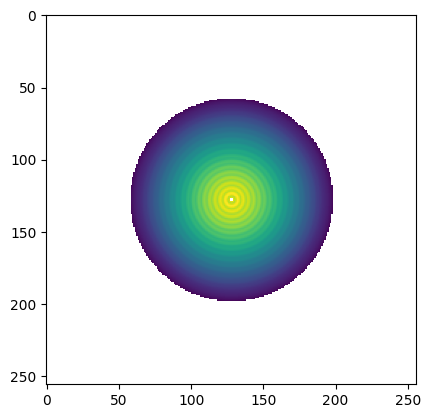

In [4]:
_, _, Cl2D = make_CMB_maps(N,pix_size,ell,DlEE, return_2D_spec = True)
plt.imshow(np.log10(Cl2D))

In [5]:
phi, phi_L = make_CMB_maps(N,pix_size,ell,pp_cl)

tau, tau_L = make_CMB_maps(N,pix_size,ell,tau_tau_cl)

alpha, alpha_L = make_CMB_maps(N,pix_size,ell,alpha_alpha_cl)

In [6]:
ly, lx, modlmap = get_ells(N, pix_size)

index_x, index_y = 60, 60
Lx = lx[index_x, index_y]
Ly = 0

L_dot_l = Lx*lx+ly*Ly

alpha_l = np.arctan(ly/lx)
alpha_L_minus_l = np.arctan((Ly-ly)/(Lx-lx))

difference = 2*(alpha_l-alpha_L_minus_l)
sin = np.sin(difference)

mode = phi_L[index_x, index_y]
mode = 1.

aniso_lensing = Cl2D+mode*Cl2D*L_dot_l*sin

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_13848/2315783049.py:10: RuntimeWarning: divide by zero encountered in divide
  alpha_L_minus_l = np.arctan((Ly-ly)/(Lx-lx))


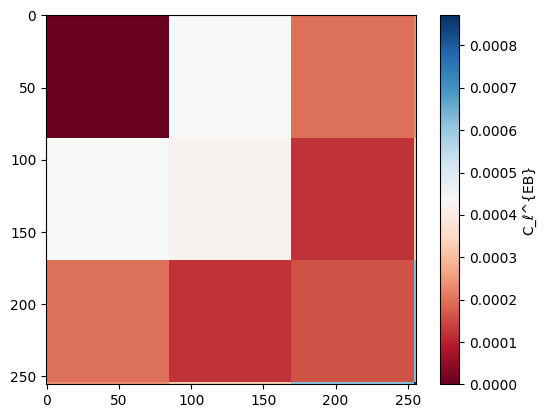

In [9]:
aniso_lensing = Cl2D*(sin*L_dot_l)
EB_power = np.abs(Cl2D)

im = plt.pcolormesh(lx, ly, EB_power, 
                    cmap='RdBu',
                    shading='auto')
plt.colorbar(im, label='C_ℓ^{EB}')

plt.imshow(EB_power)

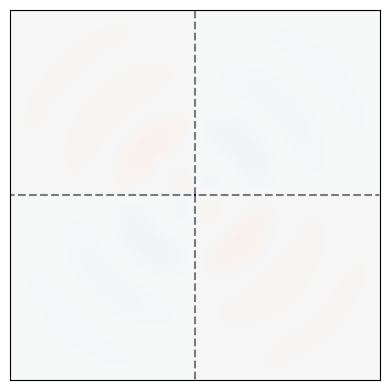

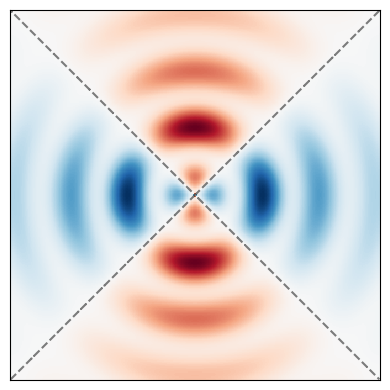

In [40]:
import numpy as np
import matplotlib.pyplot as plt

def get_EE_power(l):
    """
    Simple model for EE power spectrum
    """
    # Rough approximation of EE shape
    ls = np.arange(len(DlEE))
    return np.interp(l, ls, DlEE)

def compute_EB_power(lx, ly, gamma_plus):
    """
    Compute EB power spectrum under shear according to eq 2.11
    C̃EB_ℓ = -2CEE_ℓ [γ× cos(2φℓ) - γ+ sin(2φℓ)]
    Here we use only γ+ for simplicity
    """
    l = np.sqrt(lx**2 + ly**2)
    phi_l = np.arctan2(ly, lx)
    
    # Get base EE power
    CEE = get_EE_power(l)
    
    # Apply shear transformation
    # Using negative gamma_plus to match Figure 6 orientation in the paper
    CEB = -2 * CEE * (-gamma_plus * np.sin(2*phi_l))
    
    return CEB


def compute_EB_power_rot(lx, ly, gamma_plus):
    """
    Compute EB power spectrum under shear according to eq 2.11
    C̃EB_ℓ = -2CEE_ℓ [γ× cos(2φℓ) - γ+ sin(2φℓ)]
    Here we use only γ+ for simplicity
    """
    l = np.sqrt(lx**2 + ly**2)
    phi_l = np.arctan2(ly, lx)
    
    # Get base EE power
    CEE = get_EE_power(l)
    
    # Apply shear transformation
    # Using negative gamma_plus to match Figure 6 orientation in the paper
    CEB = -2 * CEE * (-gamma_plus * np.cos(2*phi_l))
    
    return CEB

# Set up grid
lmax = 1000
nl = 300
l = np.linspace(-lmax, lmax, nl)
LX, LY = np.meshgrid(l, l)

# Compute power spectra
gamma_plus = 0.2  # Shear strength
EB_power = compute_EB_power(LX, LY, gamma_plus)
EB_power_rot = compute_EB_power_rot(LX, LY, gamma_plus)

# Plot
plt.figure(figsize=(4, 4))
im = plt.pcolormesh(LX, LY, EB_power, 
                    cmap='RdBu',
                    shading='auto')
#plt.colorbar(im, label='C_ℓ^{EB}')

# Add multipole labels
#¶plt.xlabel('ℓ_x')
#plt.ylabel('ℓ_y')
#plt.title('2D EB Power Spectrum Under Shear (γ+ = 0.2)')

# Add zero contours
plt.contour(LX, LY, EB_power, levels=[0], colors='k', linestyles='--', alpha=0.5)

# Make plot square and centered
plt.yticks([])
plt.xticks([])
plt.axis('square')
plt.tight_layout()
plt.show()



plt.figure(figsize=(4, 4))
im = plt.pcolormesh(LX, LY, EB_power_rot, 
                    cmap='RdBu')
                    #shading='auto')
# Add zero contours
plt.contour(LX, LY, EB_power_rot, levels=[0], colors='k', linestyles='--', alpha=0.5)

# Make plot square and centered
plt.axis('square')
plt.yticks([])
plt.xticks([])
plt.tight_layout()
plt.show()

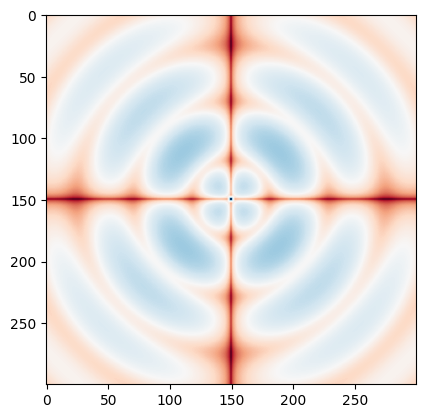

In [41]:
plt.imshow(np.log10(np.abs(EB_power)), cmap='RdBu')